## Advanced lane finder project.

#### Usage: 

Run all cells. In case of another run is needed, better restart the kernel and run all again, otherwise the images from various pipeline stages would be too numerous.

For a reference and descriptions please refer to the [project writeup](./WRITEUP.md)

In [7]:
# Setting some project-global constants
TEST_IMG_OUTPUT_PATH = "pipeline_images_output"

TEST_VIDEO_OUTPUT_PATH = "test_video_output"

IMAGE_SHAPE = (1280, 720)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
if not os.path.isdir(TEST_IMG_OUTPUT_PATH):
    os.mkdir(TEST_IMG_OUTPUT_PATH)
    
if not os.path.isdir(TEST_VIDEO_OUTPUT_PATH):
    os.mkdir(TEST_VIDEO_OUTPUT_PATH)

In [10]:
# Import everything we need from the project additional files
from camera_calibrator import CameraCalibrator, Undistorter
from lane_line import LaneLine
from bird import Bird
from plot_helper import *

In [11]:
'''
This is an inplace helper class to save images from the various pipeline stages.
If a 'DEBUG_SAVING_MODE' is False, it always does nothing; in other cases
it might be blocked (no image saving) and unblocked (image is saved whenever a
`.write()` call occurs)
'''
DEBUG_SAVING_MODE = True
class ImagePrinter():
    def __init__(self, path):
        self.path = path
        self.reset()
        
    def write(self, img, name):
        if (not DEBUG_SAVING_MODE) or self.is_blocked:
            return
        filename = "{:04d}_{}.jpg".format(self.number, name)
        self.number += 1
        cv2.imwrite(os.path.join(self.path, filename), img)

    def reset(self):
        self.number = 0
        self.is_blocked = False
        
    def block(self):
        self.is_blocked = True
        
    def unblock(self):
        self.is_blocked = False
        

In [12]:
imgprinter = ImagePrinter(TEST_IMG_OUTPUT_PATH)

In [13]:
if not os.path.isdir(TEST_IMG_OUTPUT_PATH):
    os.mkdir(TEST_IMG_OUTPUT_PATH)
test_images = [ 'test_images/{}'.format(filename) for filename in os.listdir("test_images/") ]
test_images.sort()
print(test_images)

['test_images/challenge01.jpg', 'test_images/challenge3.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


In [14]:
calibrator = CameraCalibrator(9, 6)
calibrator.calibrate()

Resetting Calibrator ...
Searching for calibration images at  camera_cal/*.jpg
20 files found for calibration.
Crunching camera_cal/calibration19.jpg ...
Crunching camera_cal/calibration20.jpg ...
Crunching camera_cal/calibration13.jpg ...
Crunching camera_cal/calibration15.jpg ...
Crunching camera_cal/calibration18.jpg ...
Crunching camera_cal/calibration2.jpg ...
Crunching camera_cal/calibration1.jpg ...
Crunching camera_cal/calibration17.jpg ...
Crunching camera_cal/calibration16.jpg ...
Crunching camera_cal/calibration5.jpg ...
Crunching camera_cal/calibration10.jpg ...
Crunching camera_cal/calibration8.jpg ...
Crunching camera_cal/calibration6.jpg ...
Crunching camera_cal/calibration4.jpg ...
Crunching camera_cal/calibration3.jpg ...
Crunching camera_cal/calibration12.jpg ...
Crunching camera_cal/calibration14.jpg ...
Crunching camera_cal/calibration7.jpg ...
Crunching camera_cal/calibration9.jpg ...
Crunching camera_cal/calibration11.jpg ...
Calibration successful


In [15]:
mtx, dist = calibrator.get_calibration_data()
undistorter = Undistorter(mtx, dist)

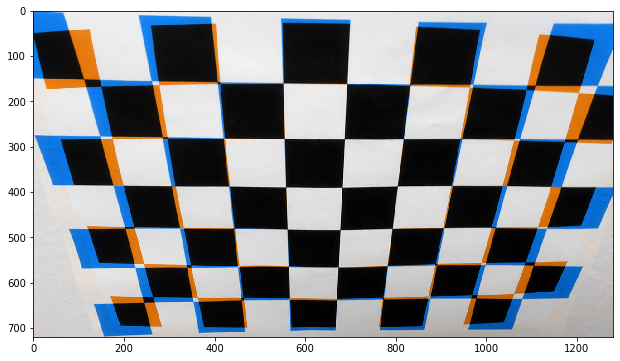

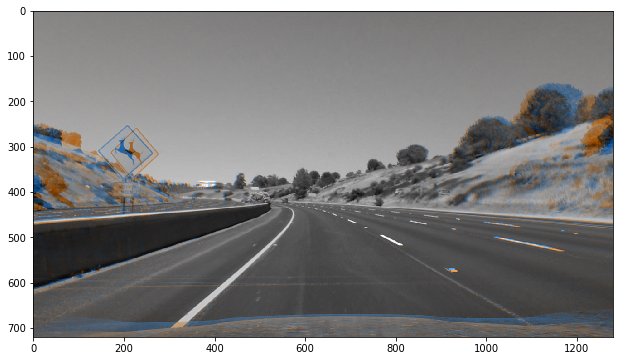

In [16]:
#
#    Calibrator and Undistorter validation
#

for filename in ['camera_cal/calibration2.jpg', test_images[5]]:
    img = cv2.imread(filename)
    distorted = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    undistorted = undistorter.undistort(distorted)

    out_shape = [undistorted.shape[0], undistorted.shape[1], 3]
    output = np.zeros(out_shape, dtype=np.uint8)
    output[:,:,0] = distorted
    output[:,:,1] = distorted//2 + undistorted//2
    output[:,:,2] = undistorted

    imgprinter.write(distorted, "distorted")
    imgprinter.write(undistorted, "undistorted")
    imgprinter.write(output, "undistorted_plus_distorted")

    plot_bgr(output)

In [17]:
def normalize(img):
    """ Expects a 2D numpy array of any type, representing a grayscale image """
    """ Returns an np.uint8 array with range 0..255 """
    minimum = np.min(img)
    maximum = np.max(img)
    normalized = (((img.astype(np.int16) + minimum) / (maximum - minimum) ) * 255).astype(np.uint8)
    return normalized

In [18]:
#
#  ROIs for the regular and challenge video (they differs for some reason)
#
h_center = 640
h_offset = 50
top = 450
bottom = 690
left = 210
right = 1070
REGULAR_CAMERA_ROI = np.array([[left, bottom],
                [h_center - h_offset, top],
                [h_center + h_offset, top],
                [right, bottom]]
               , np.int32)

h_center = 640
h_offset = 70
top = 475
bottom = 690
left = 210
right = 1070
CHALLENGE_CAMERA_ROI = np.array([[left, bottom],
                [h_center - h_offset, top],
                [h_center + h_offset, top],
                [right, bottom]]
               , np.int32)

CAMERA_ROI = REGULAR_CAMERA_ROI

birds_top = 0
birds_bottom = 720
birds_left = left +50
birds_right = right -50
BIRD_ROI =  np.float32([[birds_left, birds_bottom],
                       [birds_left, birds_top],
                       [birds_right, birds_top],
                       [birds_right, birds_bottom]])

bird = Bird(BIRD_ROI, CAMERA_ROI.astype(np.float32))

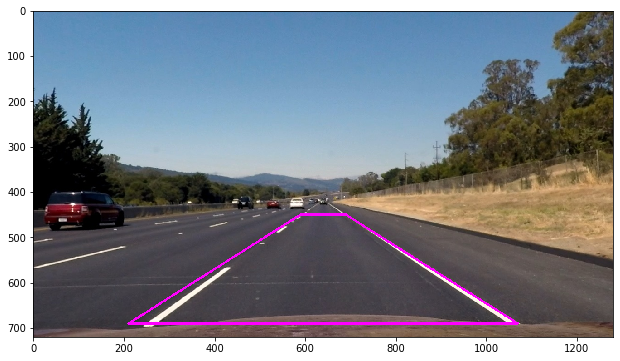

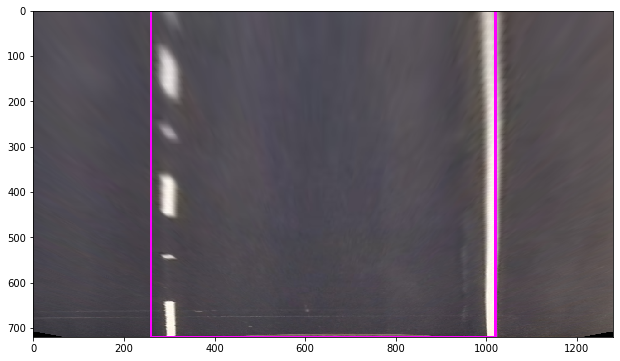

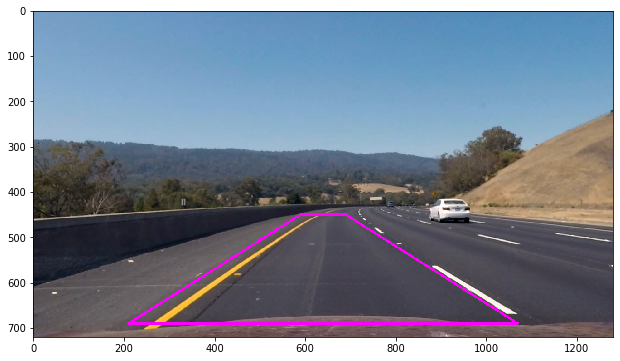

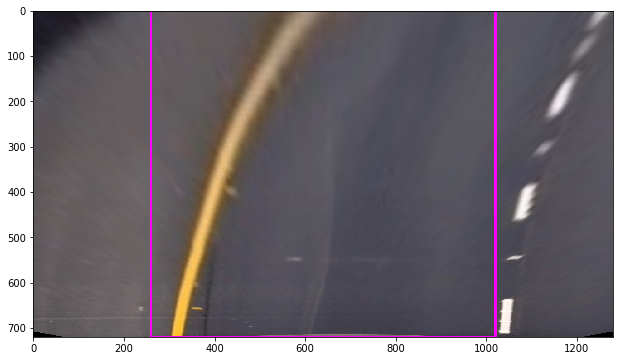

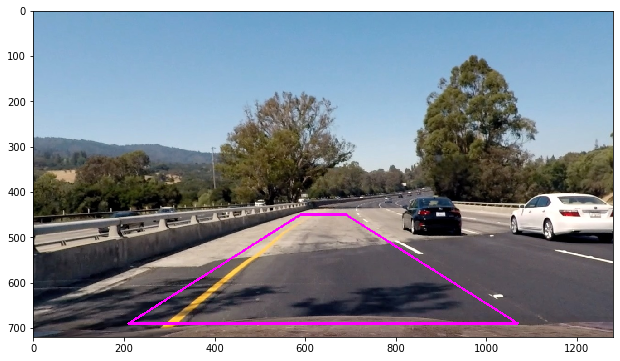

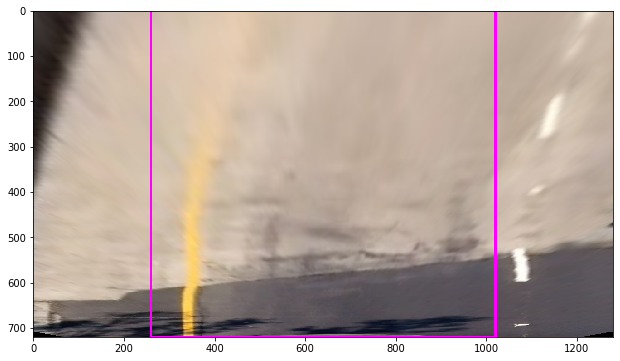

In [19]:
#
# Validate the warp transform
# https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html
#
for test_img in [3,6,7]: # 3,6 and 7 are good examples for warp transform

    img = cv2.resize(cv2.imread(test_images[test_img]), IMAGE_SHAPE)
    
    fpv = undistorter.undistort(img)
    
    fpv_roi = plot_roi(fpv, CAMERA_ROI)
    imgprinter.write(fpv_roi, "transform_roi")
        
    plot_bgr(fpv_roi)
    
    birds_eye = plot_roi(bird.from_above(fpv), BIRD_ROI.astype(np.int32))
    imgprinter.write(birds_eye, "birds_eye")

    plot_bgr(birds_eye)

In [20]:
def subtract_major_tone(img, downsample_rate=2, accuracy=20):
    """ 
    Finds the nmost popular pixel brightness (major tone) 
    and then subtracts it from the whole image. This way we shift
    brightness curve without adding significant artifacts (as opposed
    to a regular thresholding)
    """
    hist = np.histogram(img[::downsample_rate, ::downsample_rate], accuracy)
    major = hist[1][np.argmax(hist[0])]
    if (major <= 1.0):
        # In some cases, the most popular pixel in an image is black
        # and so there's nothing to subtract; but still we believe
        # the lane markings to be the brightest, and just
        # subtract the _second_ most popular pixel brightness.
        second_max = np.partition(hist[0], -2)[-2]
        second_max_idx = np.where(hist[0] == second_max)[0][0]
        major = hist[1][second_max_idx]

    return np.maximum(0, img.astype(np.int32) - major)

def adaptive_vertical_contrast(img, downsample_rate=2, save_output=False):
    """ Expects a cv2 mat (in BGR) as input """
    # The idea is to mix Lum and Sat channels to improve lane lines visibility
    height, width = img.shape[:2]
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    imgprinter.write(hls[::downsample_rate, ::downsample_rate, :], "hls_color_space")
    
    # Downsampling significantly increases processing speed
    # while introducing only a minor artifacts
    B = img[::downsample_rate, ::downsample_rate, 0].astype(np.int16)
    G = img[::downsample_rate, ::downsample_rate, 1].astype(np.int16)
    R = img[::downsample_rate, ::downsample_rate, 2].astype(np.int16)
    
    quarter_lum = hls[::downsample_rate, ::downsample_rate, 1]
    quarter_sat = hls[::downsample_rate, ::downsample_rate, 2]
    imgprinter.write(quarter_lum, "luminosity")
    imgprinter.write(quarter_sat, "saturation")

    # Yellow lane marking is the best recognizeable as a sum of
    # yellow and saturation channels
    yellow = np.maximum(0, (R + G - B))
    imgprinter.write(yellow, "yellow")
    filtered_yellow = subtract_major_tone(yellow)
    imgprinter.write(filtered_yellow, "yellow_balanced")

    yell_sat = quarter_sat//2 + filtered_yellow//2
    imgprinter.write(yell_sat, "sat_plus_yellow")
    
    min_lum = subtract_major_tone(subtract_major_tone(quarter_lum))
    imgprinter.write(min_lum, "luminosity_balanced")
    lum_part = normalize(np.minimum(np.power(min_lum, 2), 2500))
    imgprinter.write(lum_part, "luminosity_highcontrast")

    yellsat_balanced = subtract_major_tone(subtract_major_tone(yell_sat))
    imgprinter.write(yellsat_balanced, "yellsat_balanced")
    yellsat_highcontrast = normalize(np.minimum(np.power(yellsat_balanced, 2), 2000))
    imgprinter.write(yellsat_highcontrast, "yellsat_highcontrast")

    mix = np.uint16(np.maximum(yellsat_highcontrast, lum_part))
    imgprinter.write(mix, "yellsat_mix_lum")
    mix = normalize(np.power(mix, 2))
    imgprinter.write(mix, "yellsat_mix_lum_highcontrast")

    output = cv2.resize(mix, (width, height))
    return output

In [21]:
def amplify_vert_lane_pixels(gray_input, sobel_kernel=5,
                             angle_range=(-0.5, 0.5), magnitude_range=(20,255),
                             downsample_rate=4, save_output=False):
    """ 
    Finds and amplifies pixels that belongs to geometrical
    structures, similar to lane line markings
    """
    downsample = gray_input[::downsample_rate, ::downsample_rate]

    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(downsample, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    imgprinter.write(normalize(abs_sobelx), "abs_sobelx_kernel_{}".format(sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(downsample, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    imgprinter.write(normalize(abs_sobely), "abs_sobely_kernel_{}".format(sobel_kernel))

    # Calculate the direction of the gradient and select only pixels
    # near edges of the matching slope (to the 'angle_range' in radians)
    angles = np.arctan2(abs_sobely, abs_sobelx)
    imgprinter.write(normalize(angles), "gradient_angles")
    (angle_min, angle_max) = angle_range

    # Calculate magnitude of the gradient
    mag_raw = normalize(np.sqrt(np.power(abs_sobelx, 2) + np.power(abs_sobely, 2)))
    imgprinter.write(normalize(mag_raw), "gradient_magnitude")
    min_magnitude, max_magnitude = magnitude_range;

    # Combining thresholds
    combined = np.zeros_like(downsample)
    combined[(((mag_raw > min_magnitude) & (mag_raw <= max_magnitude))\
              & ((angles >= angle_min) & (angles <= angle_max)))] = 255
    imgprinter.write(normalize(combined), "angle_magnitude_combined")
    output = cv2.resize(normalize(combined), (gray_input.shape[1], gray_input.shape[0]))

    return output

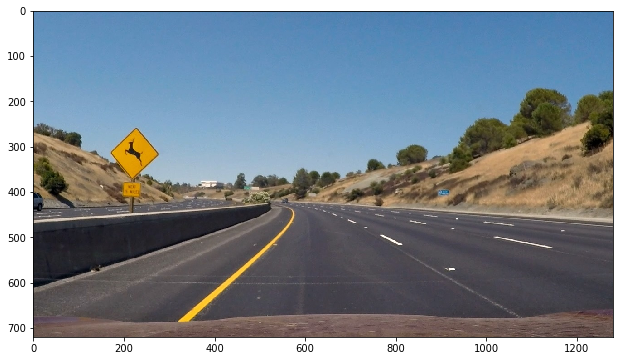

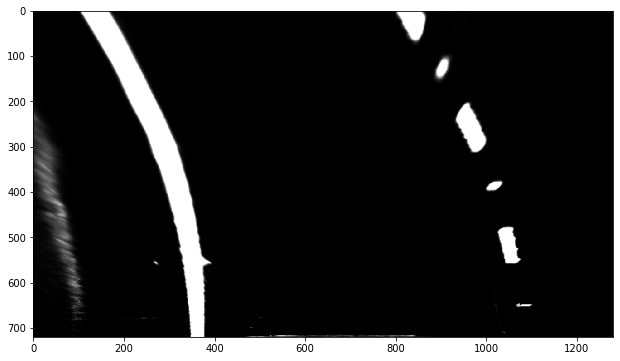

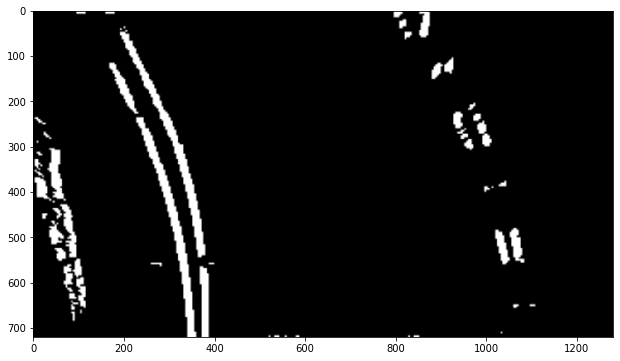

In [22]:
#
# Validate the pixel contrast and pixel orientation pipeline; plot pipeline frames
#
for test_img in test_images[5:6]:
    imgprinter.unblock()
    img = cv2.resize(cv2.imread(test_img), IMAGE_SHAPE)
    bird_eye = bird.from_above(undistorter.undistort(img))
    highcontrast = adaptive_vertical_contrast(bird_eye)
    probable_lane_pixels = amplify_vert_lane_pixels(highcontrast)
    plot_bgr(img)
    plot_gray(highcontrast)
    plot_gray(probable_lane_pixels)

In [23]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 27/720 # meters per pixel in y dimension for the regular video
xm_per_pix = 3.75/713 # meters per pixel in x dimension for the regular video

In [24]:
# The lane finding method taken from the course
def find_lane_pixels(binary_warped, debug_img=None):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                      (win_xleft_high, win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                      (win_xright_high, win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix: 
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    if debug_img is not None:
        debug_img[:,:,:] = out_img[:,:,:]
    return leftx, lefty, rightx, righty

In [25]:
def take_lane_pixels(binary_warped, lcurve, rcurve, margin=50, debug_img=None):
    """
    Expects lcurve and rcurve as array of points.
    Vertical stride along the curve must be the same, and must be
    equal across both curves.
    These points are used as window origins: the point is a [bottom, h_center] of a window.
    Curves must be consistent with an image (e.g. of the same height and compatible width)
    """
    assert(len(lcurve) > 2 and len(rcurve) > 2)
    l_v_stride = lcurve[1][1] - lcurve[0][1]
    r_v_stride = rcurve[1][1] - rcurve[0][1]
    assert(l_v_stride == r_v_stride)
    v_stride = l_v_stride
    leftx = []; lefty = []; rightx = []; righty = []
    # Copy the existing lane pixels to a debug image
    if debug_img is not None:
        debug_img[:,:] = binary_warped[:,:]
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    for point in lcurve:
        x, y = point
        w_left = x - margin; w_right = x + margin
        w_top = y; w_bottom = y + v_stride
        window = binary_warped[w_top:w_bottom, w_left:w_right]
        w_y_indices, w_x_indices = window.nonzero()
        if len(w_x_indices > 0):
            leftx.append(w_x_indices + w_left-1)
            lefty.append(w_y_indices + w_top-1)
        # Display the search window on a debug image
        if debug_img is not None:
            debug_img[y:y+v_stride, w_left:w_right] = 100
    for point in rcurve:
        x, y = point
        w_left = x - margin; w_right = x + margin
        w_top = y; w_bottom = y + v_stride
        window = binary_warped[w_top:w_bottom, w_left:w_right]
        w_y_indices, w_x_indices = window.nonzero()
        if len(w_x_indices > 0):
            rightx.append(w_x_indices + w_left-1)
            righty.append(w_y_indices + w_top-1)
        # Display the search window on a debug image
        if debug_img is not None:
            debug_img[y:y+v_stride, w_left:w_right] = 100
    leftx = np.concatenate(leftx) if len(leftx) > 0 else np.uint16([])
    lefty = np.concatenate(lefty) if len(lefty) > 0 else np.uint16([])
    rightx = np.concatenate(rightx) if len(rightx) > 0 else np.uint16([])
    righty = np.concatenate(righty) if len(righty) > 0 else np.uint16([])
    return leftx, lefty, rightx, righty

In [26]:
def fit_polynomial(binary_warped, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix):
    if (len(leftx) == 0 or len(lefty) == 0 or len(rightx) == 0 or len(righty) == 0):
        salted = get_lane_template_birdeye(binary_warped.shape)
        leftx, lefty, rightx, righty = find_lane_pixels(salted)
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit, right_fit


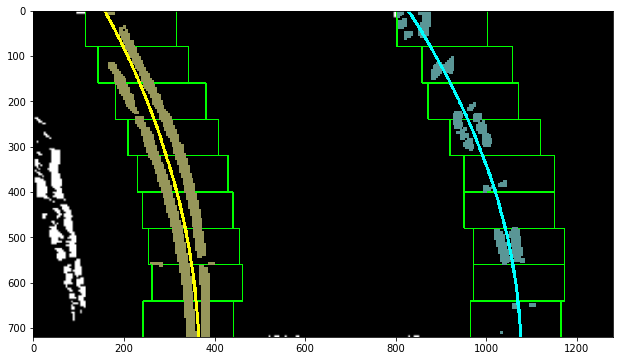

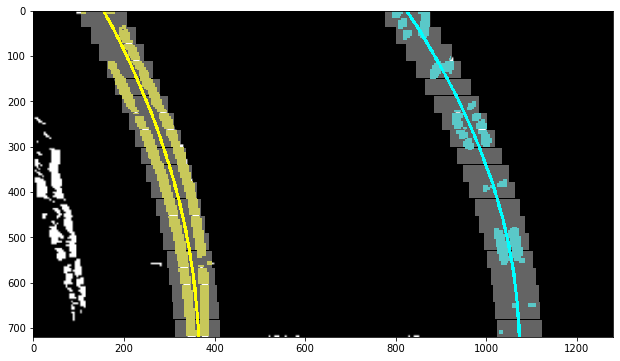

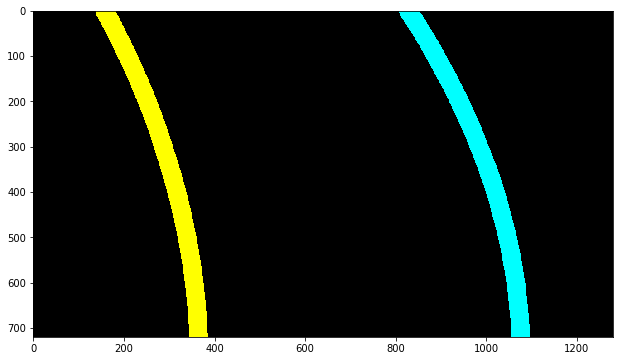

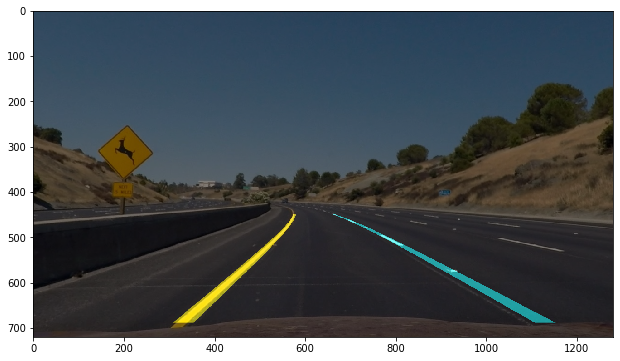

In [27]:
# Validate lane pixel finding via sliding window
for test_img in test_images[5:6]:
    imgprinter.block()
    img = cv2.resize(undistorter.undistort(cv2.imread(test_img)), IMAGE_SHAPE)
    hls = adaptive_vertical_contrast(bird.from_above(img))
    probable_lane_pixels = amplify_vert_lane_pixels(hls)

    # Debug image for find_lane_pixels will show the search windows
    debug_image_3ch = np.zeros_like(img)
    lx, ly, rx, ry = find_lane_pixels(probable_lane_pixels, debug_image_3ch)
    
    cv2.imwrite("bird_eye.png", probable_lane_pixels)
    lfit, rfit = fit_polynomial(probable_lane_pixels, lx, ly, rx, ry, xm_per_pix, ym_per_pix)
    lcurve, rcurve = get_plottable_curves(img.shape[0], lfit, rfit, xm_per_pix, ym_per_pix)
    
    # Debug image for take_lane_pixels will show the taking process areas
    debug_img_1ch = np.zeros_like(probable_lane_pixels)
    lx2,ly2,rx2,ry2 = take_lane_pixels(probable_lane_pixels, lcurve, rcurve, debug_img=debug_img_1ch)
    lfit2, rfit2 = fit_polynomial(probable_lane_pixels, lx2, ly2, rx2, ry2, xm_per_pix, ym_per_pix)
    lcurve2, rcurve2 = get_plottable_curves(img.shape[0], lfit2, rfit2, xm_per_pix, ym_per_pix)

    found = debug_image_3ch
    found[ly, lx] = [90, 150 , 150]
    found[ry, rx] = [150, 150, 90]
    found = plot_lane_curves(found, lcurve, rcurve)

    lcurv = LaneLine.curvature(lfit, 720 * ym_per_pix)
    rcurv = LaneLine.curvature(rfit, 720 * ym_per_pix)
      
    imgprinter.unblock()
    plot_bgr(found)
    imgprinter.write(found, "found_lane_pixels")
    
    taken = cv2.cvtColor(debug_img_1ch, cv2.COLOR_GRAY2BGR)
    taken = np.maximum(taken, cv2.cvtColor(probable_lane_pixels, cv2.COLOR_GRAY2BGR))
    taken[ly2, lx2] = [90, 200 , 200]
    taken[ry2, rx2] = [200, 200, 90]
    taken = plot_lane_curves(taken, lcurve2, rcurve2)
    plot_bgr(taken)
    imgprinter.write(taken, "taken_lane_pixels")

    
    lane_curves_from_above = plot_lane_curves(np.zeros_like(found), lcurve, rcurve, thickness=40)
    plot_bgr(lane_curves_from_above)
    
    lane_curves_on_road = bird.to_road(lane_curves_from_above)
    demo = np.uint8((img.astype(np.uint16) + lane_curves_on_road)//2)
    plot_bgr(demo)
    imgprinter.write(demo, "demo_lanes_detected")

In [28]:
# The main processing pipeline

def process_frame(input_frame, plot_many=False):
    """
    Expects an input RGB frame.
    
    Requires 2 instanses of LaneLine, a Bird instance,
    an Undistorter instance, a global frame buffer for averaging,
    and a buffer averaging coefficient - all as global variables.
    
    Processes a raw image from the car camera, detects road lanes, computes
    lane curvature radius and center offset.
    
    If 'plot_many' is True, plots some stages of the pipeline to the output image.
    If it is False, plots only the last pipeline stage output - a road image with
    the lane polygon, curvature radiuses and center offset.
    """
    
    global buffer_frame, buf_avg
    global rlane, llane, bird, undistorter
    
    if input_frame.shape[:2] != [720, 1280]:
        frame = cv2.resize(input_frame, IMAGE_SHAPE)
    else:
        frame = input_frame
    imgprinter.block()

    is_all_ok = (llane.is_valid() and rlane.is_valid())
    downsample_rate = 2
    
    height, width, _ = frame.shape
    birds_eye = bird.from_above(undistorter.undistort(frame))
    highcontrast = adaptive_vertical_contrast(birds_eye, downsample_rate=downsample_rate)
    probable_lane_pixels = amplify_vert_lane_pixels(highcontrast, downsample_rate=downsample_rate)
    
    if buffer_frame is None:
        buffer_frame = np.uint32(probable_lane_pixels)
    else:
        buffer_frame = (buffer_frame * (buf_avg - 1) + probable_lane_pixels) / buf_avg

    filtered_stage2 = np.zeros_like(probable_lane_pixels)
    # Thresholding the buffer content
    filtered_stage2[buffer_frame > 25] = 1
    # Cleaning up a small pixel noise
    filtered_stage2 = cv2.morphologyEx(filtered_stage2, cv2.MORPH_OPEN, np.ones((5,5)))

    if is_all_ok:
        # Faster lane pixel retrieving from the image
        downsample_rate = 10
        lx, ly, rx, ry = take_lane_pixels(filtered_stage2,
                                          llane.get_curve(),
                                          rlane.get_curve(),
                                          margin=80)
    else:
        # More robust lane pixel finding on the image
        downsample_rate = 2
        lx, ly, rx, ry = find_lane_pixels(filtered_stage2)
    
    # To fit a polynome curve, we need as few points as possible, as it 
    # speeds up computations; but not too few to keep the accuracy.
    fit_downsample = 1 + max(len(lx), len(ly)) // 1000
    lfit, rfit = fit_polynomial(filtered_stage2,
                                lx[::fit_downsample],
                                ly[::fit_downsample],
                                rx[::fit_downsample],
                                ry[::fit_downsample],
                                xm_per_pix, ym_per_pix)
    llane.update(lfit); 
    rlane.update(rfit);
    
    lcurve, rcurve = get_plottable_curves(height, llane.get_fit(), rlane.get_fit()
                                          , xm_per_pix, ym_per_pix, steps=15)
    llane.set_curve(lcurve)
    rlane.set_curve(rcurve)
    
    found_lanes = plot_lane_curves(cv2.cvtColor(normalize(filtered_stage2),
                                                   cv2.COLOR_GRAY2BGR)
                                      , lcurve, rcurve)
    
    road_poly_from_above = np.zeros_like(frame)
    poly_color = [100,200,100] if is_all_ok else [255,0,0]
    plot_lane_poly_on(road_poly_from_above, lcurve, rcurve, color=poly_color)
    lane_poly = bird.to_road(road_poly_from_above)
    detection_result = np.maximum(frame, lane_poly)
    plot_radiuses_on(detection_result, llane.get_radius(), rlane.get_radius())
    plot_hcenter_offset_on(detection_result, llane.get_horizontal_offset(), rlane.get_horizontal_offset())

    if not plot_many:
        return detection_result
    
    # Compose 4 tiles - a pipeline result at top left, and some pipeline stages
    # at other 3 quarters of the output image.
    tile_00 = cv2.resize(detection_result, (width//2, height//2))
    tile_01 = cv2.cvtColor(cv2.resize(highcontrast, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_10 = cv2.cvtColor(cv2.resize(probable_lane_pixels, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_11 = cv2.resize(found_lanes, (width//2, height//2))

    output = np.zeros_like(frame)
    output [:height//2, :width//2] = tile_00
    output [:height//2, width//2:] = tile_01
    output [height//2:, :width//2] = tile_10
    output [height//2:, width//2:] = tile_11
    imgprinter.unblock()
    return output

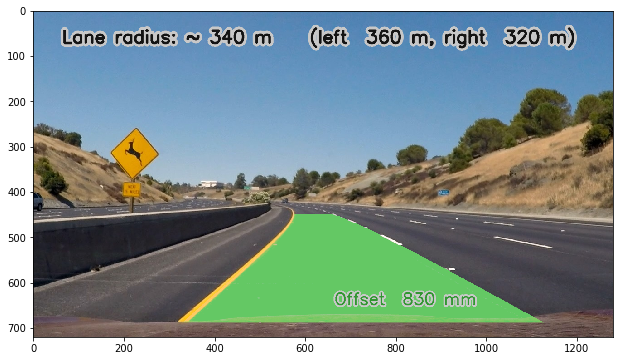

In [29]:
# Validate lane pixel finding via sliding window
rlane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=1, max_valid_diff=0.75, max_broken_frames=12, name="Right")
llane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=1, max_valid_diff=0.75, max_broken_frames=12, name="Left")

buffer_frame = None
buf_avg = 1
for test_img in test_images[5:6]:
    for i in range(0, 3): # processing the same frame several times to trigger averaging
        img = cv2.resize(cv2.imread(test_img), IMAGE_SHAPE)
        process_frame(img)
    result = process_frame(img)
    plot_bgr(result)
    cv2.imwrite(test_img.replace('test_images','output_images'), result)
    imgprinter.unblock()
    imgprinter.write(result, "pipeline_result")
    buffer_frame = None
    llane.reset()
    rlane.reset()

In [30]:
# Regular video processing

rlane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=2, max_valid_diff=0.75, max_broken_frames=12, name="Right")
llane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=2, max_valid_diff=0.75, max_broken_frames=12, name="Left")

buffer_frame = None
buf_avg = 12

input_video = 'project_video.mp4'; test_video_output = 'test_video_output/test_video.mp4'
bird = Bird(BIRD_ROI, REGULAR_CAMERA_ROI.astype(np.float32))

imgprinter.block()
regular_clip = VideoFileClip(input_video).fl_image(process_frame)
%time regular_clip.write_videofile(test_video_output, audio=False)
imgprinter.unblock()

t:   0%|          | 3/1260 [00:00<01:03, 19.68it/s, now=None]

Moviepy - Building video test_video_output/test_video.mp4.
Moviepy - Writing video test_video_output/test_video.mp4



Moviepy - Done !
Moviepy - video ready test_video_output/test_video.mp4
CPU times: user 5min 59s, sys: 3.52 s, total: 6min 3s
Wall time: 2min 37s


In [31]:
# Challenge video processing

rlane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=8, max_valid_diff=0.75, max_broken_frames=10, name="Right")
llane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=8, max_valid_diff=0.75, max_broken_frames=10, name="Left")

buffer_frame = None
buf_avg = 12

input_video = 'challenge_video.mp4'; test_video_output = 'test_video_output/challenge_test_video.mp4'

bird = Bird(BIRD_ROI, CHALLENGE_CAMERA_ROI.astype(np.float32))

imgprinter.block()
challenge_clip = VideoFileClip(input_video).fl_image(process_frame)
%time challenge_clip.write_videofile(test_video_output, audio=False)
imgprinter.unblock()

t:   0%|          | 2/485 [00:00<00:27, 17.57it/s, now=None]

Moviepy - Building video test_video_output/challenge_test_video.mp4.
Moviepy - Writing video test_video_output/challenge_test_video.mp4



t:  31%|███       | 150/485 [00:16<00:47,  7.03it/s, now=None]

ALARM! LANE Left BROKEN!
ALARM! LANE Left BROKEN!


t:  31%|███▏      | 152/485 [00:17<00:45,  7.25it/s, now=None]

ALARM! LANE Left BROKEN!


Moviepy - Done !
Moviepy - video ready test_video_output/challenge_test_video.mp4
CPU times: user 2min 16s, sys: 1.73 s, total: 2min 17s
Wall time: 59.3 s


In [32]:
# Harder challenge video processing
"""
Note: I have not found any working solution for the "harder challenge" :(
"""

'\nNote: I have not found any working solution for the "harder challenge" :(\n'